# Dataset Preparation

In [134]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
from keras.preprocessing import image

In [135]:
dataframe=pd.read_csv('dataset/train.csv')
dataframe.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [136]:
print(dataframe.shape)
dataframe=dataframe.values

(364, 2)


In [137]:
label=np.unique(dataframe[:,1])
print(label)

['bharatanatyam' 'kathak' 'kathakali' 'kuchipudi' 'manipuri'
 'mohiniyattam' 'odissi' 'sattriya']


In [138]:
dic={'bharatanatyam':0,'kathak':1,'kathakali':2, 'kuchipudi':3, 'manipuri':4,'mohiniyattam':5,'odissi':6,'sattriya':7}

In [139]:
p=Path('dataset/train/')
dirs=p.glob('*')
image_data=[]
labels=[]
for img_path in dirs:
    img_name=str(img_path).split('\\')[-1][:]
    if img_name in dataframe:
        img=image.load_img(img_path,target_size=((200,200)))
        img_array=image.img_to_array(img)
        image_data.append(img_array)
        img_name=str(img_path).split('\\')[-1][:]
        img_detail=dataframe[dataframe[:,0]==img_name]
        labels.append(dic[img_detail[0][1]])
    

In [140]:
image_data=np.array(image_data,dtype='float32')/255.0
labels=np.array(labels)

In [141]:
print(image_data.shape,labels.shape)

(364, 200, 200, 3) (364,)


# Visualise this data

In [142]:
import matplotlib.pyplot as plt

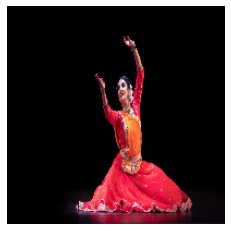

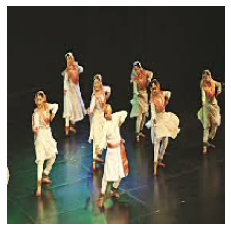

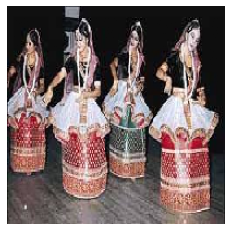

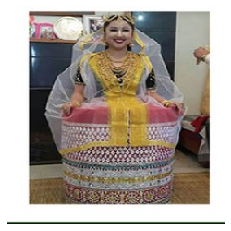

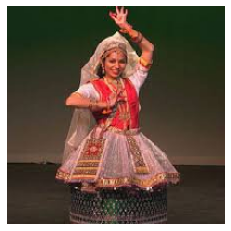

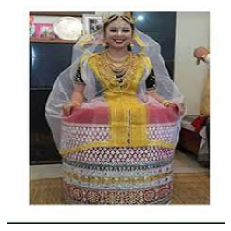

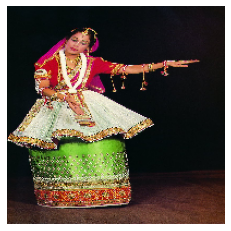

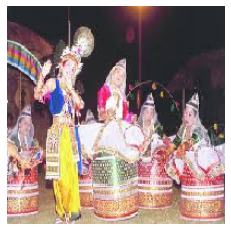

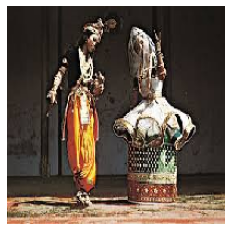

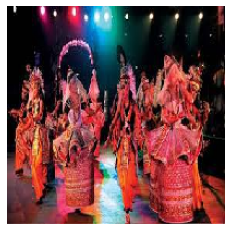

In [143]:
def drawImg(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

for i in range(10):
    drawImg(image_data[i])
    

# SVM Classifier

In [144]:
class svm:
    
    def __init__(self):
        self.w=0
        self.bias=0
    
    def hinge_loss(self,x,y,w,b,c):
        loss=0.0
        
        loss+=.5*np.dot(w,w.T)
        m=x.shape[0]
        for i in range(m):
            ti=y[i]*(np.dot(w,x[i].T)+b)
            loss+=c*max(0,(1-ti))
            
        return loss[0][0]
    
    
    def fit(self,x,y,max_itr=100,batch_size=100,learning_rate=0.01,c=1.0):
        n_feat=x.shape[1]
        n_sample=x.shape[0]
        
        n=learning_rate
        
        
        w=np.zeros((1,n_feat))
        bias=0.0
        
        loss=[]
        for i in range(max_itr):
            l=self.hinge_loss(x,y,w,bias,c)
            loss.append(l)
            for batch in range(0,n_sample,batch_size):
                grad_w=0
                grad_b=0
                for j in range(batch,batch+batch_size):
                    if j<n_sample:
                        ti=y[j]*(np.dot(w,x[j].T)+bias)
                        if ti>1:
                            grad_w+=0
                            grad_b+=0
                        else:
                            grad_w+=c*y[j]*x[j]
                            grad_b+=c*y[j]
                w=w-learning_rate*w+n*grad_w
                bias=bias+n*grad_b
        self.w=w
        self.bias=bias
        return w,bias,loss

### since our classifier in binary we need to convert data for one vs one

In [145]:
m=image_data.shape[0]
image_data=image_data.reshape(m,-1)
print(image_data.shape)

(364, 120000)


In [146]:
classes=len(label)
classes

8

In [147]:
def classWiseData(x,y):
    data={}
    for i in range(classes):
        data[i]=[]
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k]=np.array(data[k])
    
    return data

In [148]:
data=classWiseData(image_data,labels)

In [149]:
'''
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)
print(data[4].shape)
print(data[5].shape)
print(data[6].shape)
print(data[7].shape)'''

'\nprint(data[0].shape)\nprint(data[1].shape)\nprint(data[2].shape)\nprint(data[3].shape)\nprint(data[4].shape)\nprint(data[5].shape)\nprint(data[6].shape)\nprint(data[7].shape)'

In [150]:
def getDataPair(d1,d2):
    #cobines data of 2 classes into single matrix
    
    l1,l2=d1.shape[0],d2.shape[0]
    
    samples=l1+l2
    features=d1.shape[1]
    
    data_pair=np.zeros((samples,features))
    data_labels=np.zeros((samples,))
    
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    
    data_labels[:l1]= -1
    data_labels[l1:]= 1
    
    return data_pair,data_labels

# Training NC2 SVM's part

In [151]:
mysvm=svm()

In [152]:
def trainSVM(x,y):
    svm_classifiers={}
    for i in range(classes):
        svm_classifiers[i]={}
        for j in range(i+1,classes):
            xpair,ypair=getDataPair(data[i],data[j])
            w,b,loss=mysvm.fit(xpair,ypair,max_itr=500,learning_rate=0.001,c=2.0)
            svm_classifiers[i][j]=(w,b)
            
    return svm_classifiers
        

In [153]:
svm_classifiers=trainSVM(image_data,labels)

# prediction

In [154]:
def binaryPrediction(x,w,b):
    z=np.dot(x,w.T)+b
    if z>=0:
        return 1
    else:
        return -1


In [155]:
def predict(x):
    
    count=np.zeros((classes,))
    
    for i in range(classes):
        for j in range(i+1,classes):
            w,b=svm_classifiers[i][j]
            #Take a majority prediction
            z=binaryPrediction(x,w,b)
            
            if z==1:
                count[j]+=1
            else:
                count[i]+=1
    return np.argmax(count)

In [156]:
print(predict(image_data[1])) #prediction
print(labels[1]) # actual value

1
1


In [157]:
def accuracy(x,y):
    count=0
    
    for i in range(x.shape[0]):
        prediction=predict(x[i])
        if prediction==y[i]:
            count+=1
    return count/y.shape[0]

In [158]:
accuracy(image_data,labels)

1.0

# Test

In [159]:
test=pd.read_csv('dataset/test.csv')
print(test.head())

     Image
0  508.jpg
1  246.jpg
2  473.jpg
3  485.jpg
4  128.jpg


In [160]:
test_dataName=test.values
print(test_dataName)

[['508.jpg']
 ['246.jpg']
 ['473.jpg']
 ['485.jpg']
 ['128.jpg']
 ['410.jpg']
 ['465.jpg']
 ['196.jpg']
 ['340.jpg']
 ['467.jpg']
 ['306.jpg']
 ['171.jpg']
 ['323.jpg']
 ['332.jpg']
 ['330.jpg']
 ['170.jpg']
 ['479.jpg']
 ['9.jpg']
 ['283.jpg']
 ['114.jpg']
 ['507.jpg']
 ['183.jpg']
 ['200.jpg']
 ['457.jpg']
 ['264.jpg']
 ['194.jpg']
 ['518.jpg']
 ['175.jpg']
 ['64.jpg']
 ['152.jpg']
 ['270.jpg']
 ['125.jpg']
 ['38.jpg']
 ['440.jpg']
 ['302.jpg']
 ['394.jpg']
 ['448.jpg']
 ['463.jpg']
 ['20.jpg']
 ['301.jpg']
 ['28.jpg']
 ['61.jpg']
 ['398.jpg']
 ['349.jpg']
 ['271.jpg']
 ['286.jpg']
 ['431.jpg']
 ['316.jpg']
 ['224.jpg']
 ['411.jpg']
 ['278.jpg']
 ['456.jpg']
 ['45.jpg']
 ['324.jpg']
 ['6.jpg']
 ['59.jpg']
 ['86.jpg']
 ['470.jpg']
 ['374.jpg']
 ['132.jpg']
 ['216.jpg']
 ['95.jpg']
 ['17.jpg']
 ['162.jpg']
 ['346.jpg']
 ['439.jpg']
 ['232.jpg']
 ['150.jpg']
 ['401.jpg']
 ['145.jpg']
 ['23.jpg']
 ['514.jpg']
 ['193.jpg']
 ['416.jpg']
 ['447.jpg']
 ['220.jpg']
 ['505.jpg']
 ['147.jpg']
 

In [166]:
p=Path('dataset/test/')
test_dirs=p.glob('*')
test_data=[]
names=[]
for img_path in test_dirs:
    img_name=str(img_path).split('\\')[-1][:]
    img=image.load_img(img_path,target_size=(200,200))
    img_array=image.img_to_array(img)
    test_data.append(img_array)
    img_name=str(img_path).split('\\')[-1][:]
    names.append(img_name)

In [167]:
test_data=np.array(test_data)
test_data=test_data.reshape((test_data.shape[0],-1))

In [168]:
names=np.array(names)
names[0]

'108.jpg'

In [169]:
test_data=test_data.reshape((test_data.shape[0],-1))
test_data.shape

(156, 120000)

In [170]:
pred=[]
for i in range(test_data.shape[0]):
    prediction=predict(test_data[i])
    for key ,value in dic.items():
        if value==prediction:
            pred.append([names[i],key])

In [171]:
pred=np.array(pred)
pred[:20]

array([['108.jpg', 'kathak'],
       ['11.jpg', 'kuchipudi'],
       ['110.jpg', 'manipuri'],
       ['112.jpg', 'manipuri'],
       ['114.jpg', 'odissi'],
       ['119.jpg', 'bharatanatyam'],
       ['125.jpg', 'odissi'],
       ['128.jpg', 'kathak'],
       ['129.jpg', 'sattriya'],
       ['13.jpg', 'sattriya'],
       ['132.jpg', 'sattriya'],
       ['138.jpg', 'sattriya'],
       ['14.jpg', 'kathak'],
       ['145.jpg', 'bharatanatyam'],
       ['146.jpg', 'kathak'],
       ['147.jpg', 'odissi'],
       ['150.jpg', 'kuchipudi'],
       ['152.jpg', 'bharatanatyam'],
       ['157.jpg', 'odissi'],
       ['162.jpg', 'kathakali']], dtype='<U13')

In [172]:
dance=[]
for i in range(test_dataName.shape[0]):
    for j in range(pred.shape[0]):
        if test_dataName[i]==pred[j,0]:
            dance.append(pred[j,1])
            pred=np.delete(pred,j,0)
            break

In [173]:
dataframe=pd.DataFrame({'Image':test_dataName[:,0],'target':dance})

In [174]:
dataframe[dataframe['target']=='kathakali']

,Image,target
0,508.jpg,kathakali
8,340.jpg,kathakali
21,183.jpg,kathakali
22,200.jpg,kathakali
25,194.jpg,kathakali
39,301.jpg,kathakali
53,324.jpg,kathakali
63,162.jpg,kathakali
66,232.jpg,kathakali
75,220.jpg,kathakali


In [175]:
dataframe.to_csv('prediction.csv',index=False)